# Using Bayesian Network to predict if a song of Spotify will be an hit or not

In [1]:
pip install pgmpy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import sys
import os

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    data_dir = 'drive/MyDrive/'
else:
    data_dir = ''

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from pgmpy.models import BayesianModel
from pgmpy.estimators import HillClimbSearch, TreeSearch, BDeuScore, MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from pgmpy.independencies import IndependenceAssertion

## Data and preprocessing
The dataset is taken from [Kaggle - London bike sharing dataset](https://www.kaggle.com/datasets/hmavrodiev/london-bike-sharing-dataset).

This dataset contains 17414 entries. Each entry represents the bike rental data for the city of London at an interval of 1 hour. The data was collected between the 1st of April 2015 and the 1st of March 2017.
The dataset reports the following features for each entry:
 - **timestamp**: time of the collected data;
 - **cnt**: the amount of bike sharing rides initiated in the specified interval;
 - **t1**: the registered temperature measured in Celsius degrees;
 - **t2**: the perceived temperature in Celsius degrees;
 - **hum**: registered humidity in percentage;
 - **windspeed**: wind speed measured as km/h;
 - **weather_code**: the weather category: 1=Clear, 2=Scattered Clouds, 3=Broken Clouds, 4=Cloudy, 7=Rain, 10=Rain with Tunderstorm, 26=Snowfall;
 - **is_holiday**: True if the day of the entry is an holiday, False otherwise;
 - **is_weekend**: True if the day of the entry is in the weekend, False otherwise;
 - **season**: season of the year: 0=Spring, 1=Summer, 2=Fall, 3=Winter;

In [3]:
df = pd.read_csv(data_dir + "london_merged.csv")
print(f'Dataset contains {df.shape[0]} rows and {df.shape[1]} columns')
df.head()

Dataset contains 17414 rows and 10 columns


,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [4]:
df.describe()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
count,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000
mean,1143.101642,12.468091,11.520836,72.324954,15.913063,2.722752,0.022051,0.285403,1.492075
std,1085.108068,5.571818,6.615145,14.313186,7.894570,2.341163,0.146854,0.451619,1.118911
min,0.000000,-1.500000,-6.000000,20.500000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,257.000000,8.000000,6.000000,63.000000,10.000000,1.000000,0.000000,0.000000,0.000000
50%,844.000000,12.500000,12.500000,74.500000,15.000000,2.000000,0.000000,0.000000,1.000000
75%,1671.750000,16.000000,16.000000,83.000000,20.500000,3.000000,0.000000,1.000000,2.000000
max,7860.000000,34.000000,34.000000,100.000000,56.500000,26.000000,1.000000,1.000000,3.000000


## Preprocessing
Before constructing the network we need to preprocess the data in order to:
 1. Disretize continuous features, since pmgpy does not support continuous variables
 2. Make the features range smaller, to reduce the RAM needed by pgmpy to generate the network. This can be done by transform values in deciles.


In [60]:
data = df.copy().dropna()

# function to turn the hour of the day in intervals
def tday(h):
    time_of_day = None
    if h < 7:
        time_of_day = 0
    elif h >= 7 and h < 13:
        time_of_day = 1
    elif h >= 13 and h < 19:
        time_of_day = 2
    elif h >= 19:
        time_of_day = 3
    return time_of_day

def weather_map(w_code):
    new_code = None
    if w_code == 1:
        new_code = 0
    elif w_code == 2:
        new_code = 1
    elif w_code == 3:
        new_code = 2
    elif w_code == 4:
        new_code = 3
    elif w_code == 7:
        new_code = 4
    elif w_code == 10:
        new_code = 5
    elif w_code == 26:
        new_code = 6
    return new_code


data['timestamp'] = data['timestamp'].apply(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
data['hour'] = data['timestamp'].apply(lambda x: int(tday(x.hour)))
data = data.drop(columns='timestamp').dropna()
data['is_holiday'] = data['is_holiday'].apply(lambda x: bool(x))
data['is_weekend'] = data['is_weekend'].apply(lambda x: bool(x))
data['season'] = data['season'].apply(lambda x: int(x))
data['cnt'] = data['cnt'].apply(lambda x: int(x))
data['weather_code'] = data['weather_code'].apply(lambda x: weather_map(int(x)))

# Transformation in deciles
for col in ('t1', 't2', 'hum', 'wind_speed', 'cnt'):
    bins = pd.qcut(df[col], q=4, duplicates='drop')
    bin2int = {x: i for i, x in enumerate(bins.dtype.categories)}
    data[col] = bins.apply(lambda x: bin2int[x]).astype(np.uint8)

In [61]:
data.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour
0,0,0,0,3,0,2,False,True,3,0
1,0,0,0,3,0,0,False,True,3,0
2,0,0,0,3,0,0,False,True,3,0
3,0,0,0,3,0,0,False,True,3,0
4,0,0,0,3,0,0,False,True,3,0


## Network definition

In [62]:
data.columns

Index(['cnt', 't1', 't2', 'hum', 'wind_speed', 'weather_code', 'is_holiday',
       'is_weekend', 'season', 'hour'],
      dtype='object')

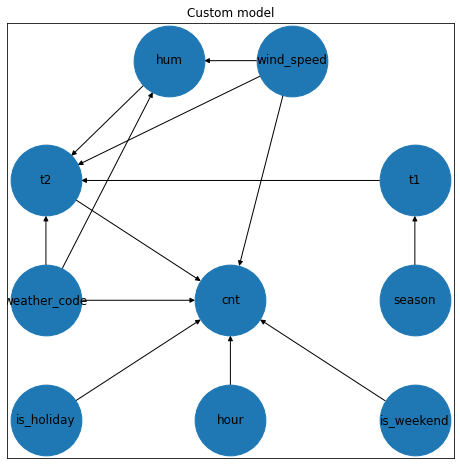

In [67]:
from pgmpy.models import BayesianNetwork

custom_model = BayesianNetwork([('t2', 'cnt'), ('wind_speed', 'cnt'),
                              ('weather_code', 'cnt'), ('is_holiday', 'cnt'), ('is_weekend', 'cnt'),
                              ('hour','cnt'),
                              ('t1','t2'), ('hum', 't2'), ('wind_speed', 't2'), ('weather_code', 't2'),
                              ('season', 't1'), ('weather_code', 't2'),
                              ('wind_speed', 'hum'), ('weather_code', 'hum')])

pos = {'cnt': [0, 1], 't1': [1.5, 1.5], 't2': [-1.5, 1.5], 'hum': [-0.5,  2],
       'wind_speed': [0.5,  2], 'weather_code': [-1.5, 1], 'is_holiday': [-1.5, 0.5],
       'is_weekend': [1.5, 0.5], 'season': [1.5,  1], 'hour': [0, 0.5]}
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
nx.draw_networkx(custom_model, pos=pos, ax=ax, node_size=5000)
ax.set_title('Custom model')

This network contains our knowledge about the problem:
- humidity is dependent on the wind speed and the weather
- the actual temperature depends on the season
- the perceived temperature is affected by the actual temperature, humidity, wind speed and the weather

Finally, the number of bike sharing rides should be affected by the perceived temperature, wind speed, the weather, the time of the day, wether the day is an holiday or not and wether the day is in the weekend or not  

To make sense of the data we can use pmgpy to count how often some variable occurs:

In [68]:
from pgmpy.estimators import ParameterEstimator
pe = ParameterEstimator(custom_model, data)
print("\n", pe.state_counts('t1'))


 season       0       1       2       3
t1                                    
0       1344.0     0.0   554.0  2497.0
1       1753.0   179.0  1358.0  1266.0
2        886.0  1092.0  1596.0   565.0
3        411.0  3116.0   795.0     2.0


We can then use a Maximum Likelihood Estimation to estimate the CPDs for the defined network: 

In [69]:
from pgmpy.estimators import MaximumLikelihoodEstimator
custom_model.fit(data, estimator=MaximumLikelihoodEstimator)
print(custom_model.get_cpds(node='t1'))

+--------+---------------------+-----+------------------------+
| season | season(0)           | ... | season(3)              |
+--------+---------------------+-----+------------------------+
| t1(0)  | 0.3058716431497497  | ... | 0.5766743648960739     |
+--------+---------------------+-----+------------------------+
| t1(1)  | 0.3989531178880291  | ... | 0.292378752886836      |
+--------+---------------------+-----+------------------------+
| t1(2)  | 0.20163859808830223 | ... | 0.13048498845265588    |
+--------+---------------------+-----+------------------------+
| t1(3)  | 0.09353664087391898 | ... | 0.00046189376443418013 |
+--------+---------------------+-----+------------------------+


## Learning the network structure

pgmpy offers the possibility to learn the structure of the bayesian network directly from the data.

We can use the Hill Climb Search algorithm:

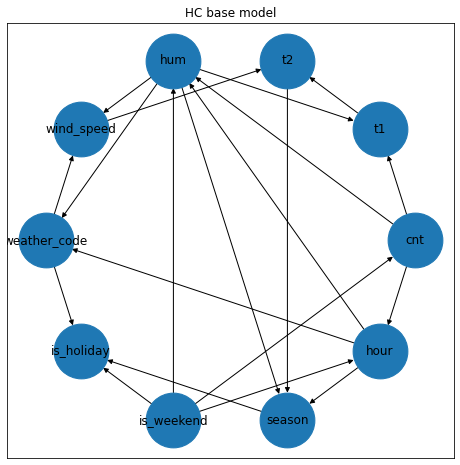

In [70]:
scorer = BDeuScore(data=data)
hc = HillClimbSearch(data=data)
hc_base_model = hc.estimate(scoring_method=scorer, show_progress=False)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
nx.draw_networkx(hc_base_model, pos=nx.drawing.layout.circular_layout(hc_base_model), ax=ax, node_size=3000)
ax.set_title('HC base model')
hc_base_model = BayesianNetwork(hc_base_model.edges())

There seems to be some problems with this network:
- cnt can not contribute to other features
- There are also some dependencies, that we know to be true, that are missing:
    - humidity -> perceived temperature
    - weather -> perceived temperature

All these problems will be solved applying some constraints.

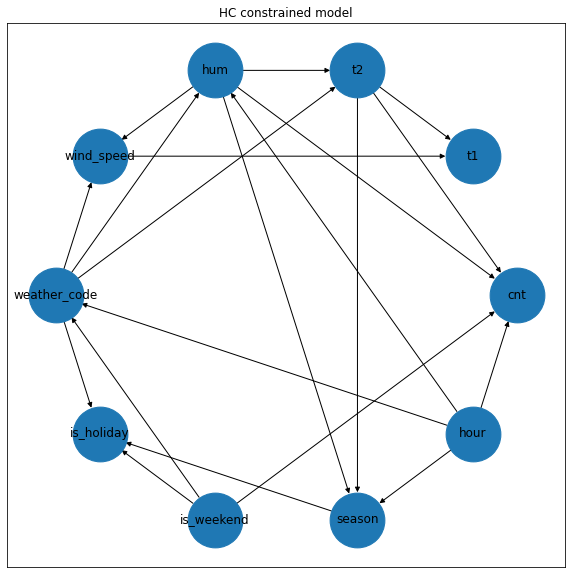

In [121]:
fixed_edges = [('hum', 't2'),('weather_code','t2')]

# On_chart cannot be the cause of anything
black_list = [('cnt', c) for c in data.columns]

scorer = BDeuScore(data=data)
hc = HillClimbSearch(data=data)
hc_constr_model = hc.estimate(scoring_method=scorer, fixed_edges=fixed_edges, black_list=black_list, show_progress=False)

#fixed_edges += [(c, 'cnt') for c in ['t2', 'hum', 'wind_speed', 'weather_code', 'is_weekend','hour','t1','is_holiday']]
#hc_fc_model = hc.estimate(scoring_method=scorer, fixed_edges=fixed_edges, black_list=black_list, show_progress=False)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
nx.draw_networkx(hc_constr_model, pos=nx.drawing.layout.circular_layout(hc_constr_model), ax=ax, node_size=3000)
#nx.draw_networkx(hc_fc_model, pos=nx.drawing.layout.circular_layout(hc_constr_model), ax=ax[1], node_size=3000)
ax.set_title('HC constrained model')
#ax[1].set_title('HC fully constrained model')

hc_constr_model = BayesianNetwork(hc_constr_model.edges())
#hc_fc_model = BayesianNetwork(hc_fc_model.edges())




In [77]:
# The tree model seems inaccurate, so it is omitted, too
hc_base_model.fit(data, estimator=MaximumLikelihoodEstimator)
hc_constr_model.fit(data, estimator=MaximumLikelihoodEstimator)
#hc_fc_model.fit(data, estimator=MaximumLikelihoodEstimator)

We can compute different scores to measure the quality of the networks

In [123]:
from pgmpy.estimators import BDeuScore, K2Score, BicScore


bdeu = BDeuScore(data, equivalent_sample_size=5)
k2 = K2Score(data)
bic = BicScore(data)


print("Scores for the custom model")
print(bdeu.score(custom_model))
print(k2.score(custom_model))
print(bic.score(custom_model))
print("Scores for the model defined with hill climb with constraints")
print(bdeu.score(hc_constr_model))
print(k2.score(hc_constr_model))
print(bic.score(hc_constr_model))
#print("Scores for the model defined with hill climb and all the constraints")
#print(bdeu.score(hc_fc_model))
#print(k2.score(hc_fc_model))
#print(bic.score(hc_fc_model))

Scores for the custom model
-174155.98771254794
-171479.3691156906
-198173.3752478609
Scores for the model defined with hill climb with constraints
-161930.019449239
-161119.88238071185
-163114.0863557763


We can see that the best model seems to be the one found with hill climbing applying the first set of constraints

In [79]:
models = [{'name': 'custom model', 'model': custom_model, 'nodes': data.columns.values.tolist()},
          {'name': 'HC base model', 'model': hc_base_model, 'nodes': data.columns.values.tolist()},
          {'name': 'HC constr model', 'model': hc_constr_model, 'nodes': data.columns.values.tolist()},]

for model in models:
  print('Considering model:', model['name'])
  print('Considering nodes:', model['nodes'])
  print(f"The total number of valid independence assertions is {len(model['model'].get_independencies().get_assertions())}")
  print(f"Local semantics of the current model:\n{model['model'].local_independencies(model['nodes'])}")
  print('Checking Markov blankets')
  for node in model['nodes']:
    print(f"The Markov blanket of node {node} is {model['model'].get_markov_blanket(node)}")
  print()

Considering model: custom model
Considering nodes: ['cnt', 't1', 't2', 'hum', 'wind_speed', 'weather_code', 'is_holiday', 'is_weekend', 'season', 'hour']
The total number of valid independence assertions is 3079
Local semantics of the current model:
(cnt ⟂ hum, t1, season | is_holiday, hour, t2, is_weekend, wind_speed, weather_code)
(t1 ⟂ is_holiday, hour, is_weekend, wind_speed, weather_code, hum | season)
(t2 ⟂ is_holiday, is_weekend, season, hour | t1, weather_code, wind_speed, hum)
(hum ⟂ is_holiday, hour, is_weekend, season, t1 | weather_code, wind_speed)
(wind_speed ⟂ is_holiday, hour, is_weekend, season, t1, weather_code)
(weather_code ⟂ is_holiday, hour, is_weekend, wind_speed, season, t1)
(is_holiday ⟂ season, t1, hum, hour, t2, is_weekend, wind_speed, weather_code)
(is_weekend ⟂ is_holiday, season, t1, hum, hour, t2, wind_speed, weather_code)
(season ⟂ is_holiday, hour, is_weekend, wind_speed, weather_code, hum)
(hour ⟂ is_holiday, season, t1, hum, t2, is_weekend, wind_speed,

## Performing inferences

### Hill climb model with constraints

In the hill climb constr model the features that directly influence cnt are:
 - t2, range {0,...,3},
 - hum, range {0,...,3},
 - is_weekend, range {True, False}
 - hour, range {0,...,3}

Let's see how they influence it.

In [80]:
inference = VariableElimination(hc_constr_model)

In [82]:
answers_t1 = []
answers_t2 = []
answers_hum = []
answers_wind_speed = []
answers_weather_code = []
answers_is_holiday = []
answers_is_weekend = []
answers_season = []
answers_hour = []

        
for score in range(4):
    for feature, answers in [('hour', answers_hour),
                             ('t2', answers_t2),
                             ('hum', answers_hum),]:
        evidence = {feature : score}
        answers.append(inference.query(["cnt"], evidence, show_progress=False).values[1])
        

for score in (True, False):
    for feature, answers in [('is_weekend', answers_is_weekend)]:
        evidence = {feature : score}
        answers.append(inference.query(["cnt"], evidence, show_progress=False).values[1])


[Text(0, 0, 'weekend'), Text(1, 0, 'no weekend')]

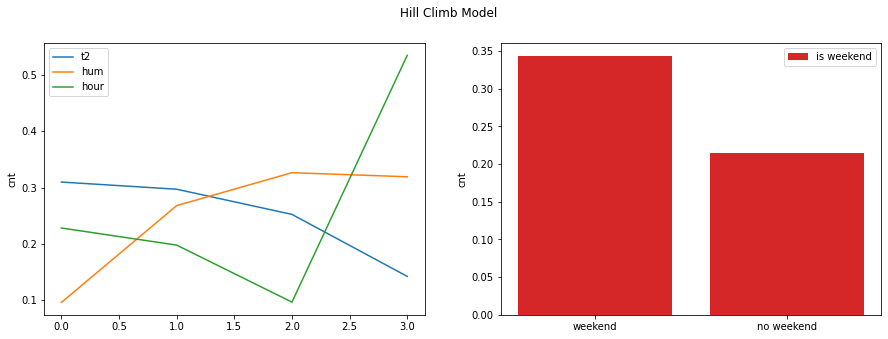

In [83]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
ax = axes[0]
fig.suptitle(f"Hill Climb Model")
ax.set_ylabel('cnt')
ax.plot(answers_t2, label='t2')
ax.plot(answers_hum, label='hum')
ax.plot(answers_hour, label='hour')
ax.legend()
ax2 = axes[1]
ax2.bar(range(2), answers_is_weekend, label='is weekend', color='C3')
ax2.legend()
ax2.set_ylabel('cnt')
ax2.set_xticks(range(2))
ax2.set_xticklabels(['weekend', 'no weekend'])

TODO comments

Now, what happens if we fix that our track has vocals?

In [84]:
answers = [[[] for _ in range(4)] for _ in range(4)]
for hour in range(4):
    for t2 in range(4):
        for hum in range(4):
            evidence = {"t2": t2, "hum": hum, 'is_weekend': True, 'hour': hour}
            answers[hour][t2].append(inference.query(["cnt"], evidence, show_progress=False).values[1])

In [85]:
def plot3d(X, Y, Z, xlabel, ylabel, zlabel, title):
    fig = plt.figure(figsize=(15, 5))
    fig.suptitle(title)
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    X, Y = np.meshgrid(X, Y)
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, edgecolor='white', cmap='viridis')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax = fig.add_subplot(1,2,2)
    CS = ax.contour(Z)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.clabel(CS, inline=True, fontsize=10)
    plt.show()

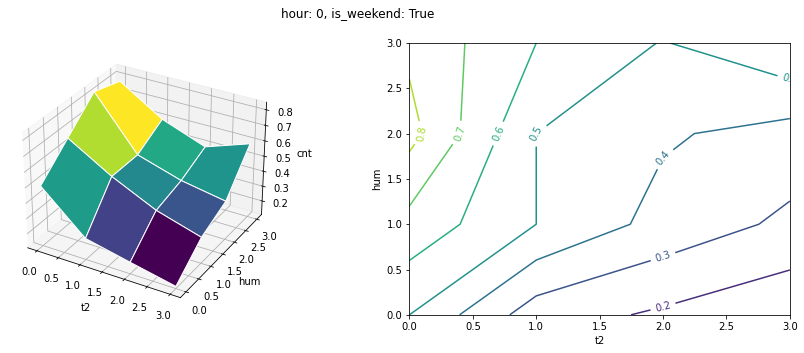

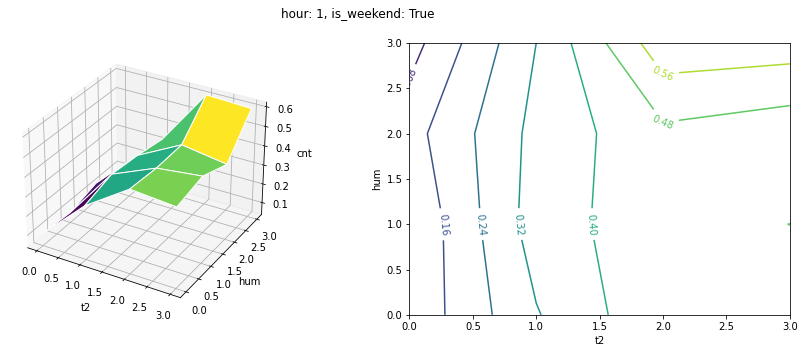

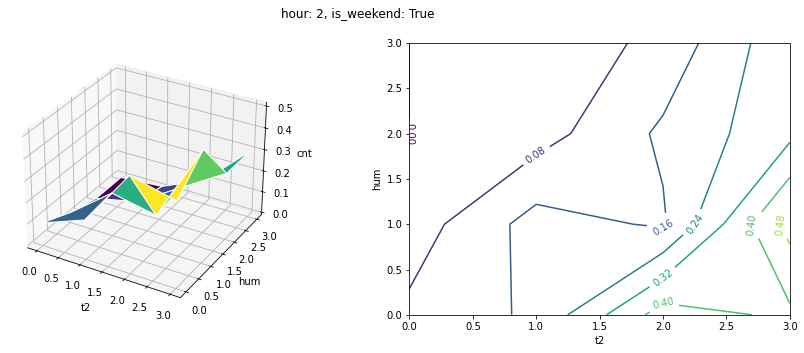

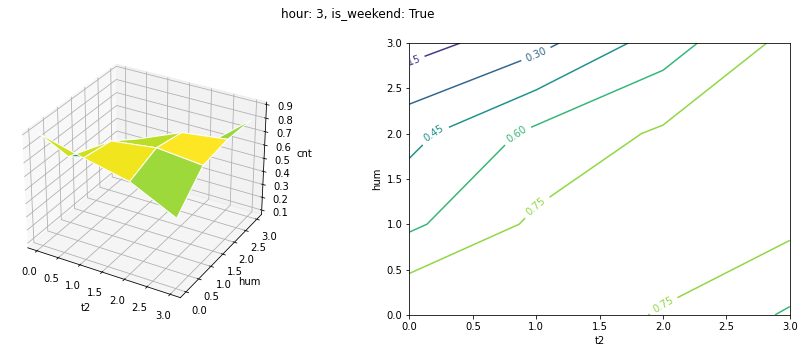

In [86]:
for i in range(4):
    plot3d(range(4), range(4), np.array(answers[i]),
         't2', 'hum', 'cnt', f'hour: {i}, is_weekend: True')

TODO comments

In [87]:
answers = [[[] for _ in range(4)] for _ in range(4)]
for hour in range(4):
    for t2 in range(4):
        for hum in range(4):
            evidence = {"t2": t2, "hum": hum, 'is_weekend': False, 'hour': hour}
            answers[hour][t2].append(inference.query(["cnt"], evidence, show_progress=False).values[1])

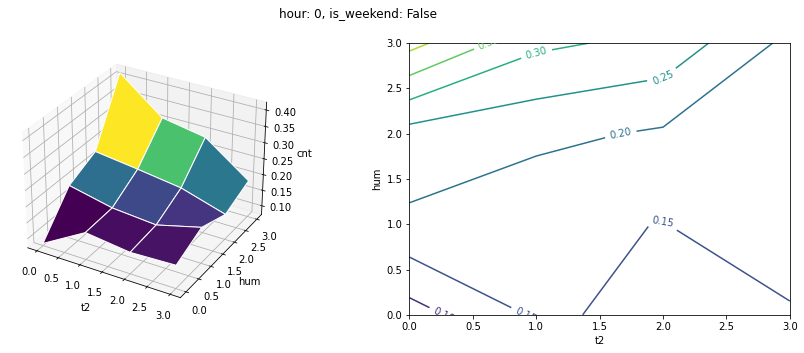

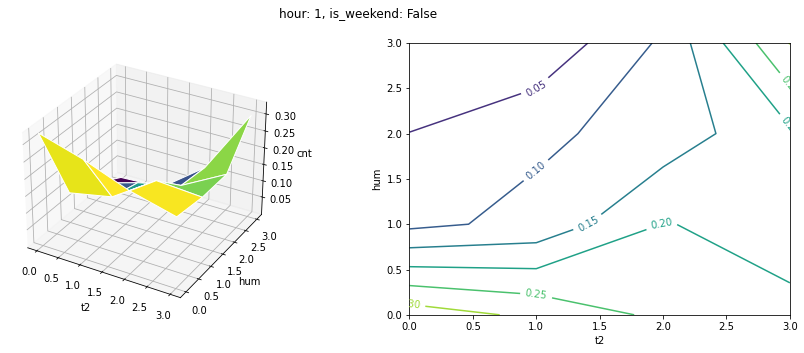

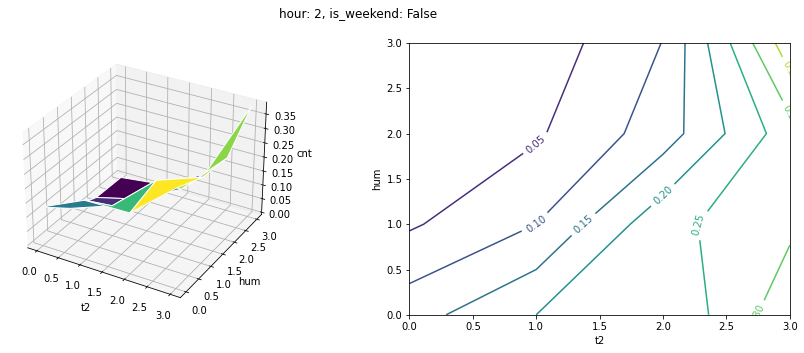

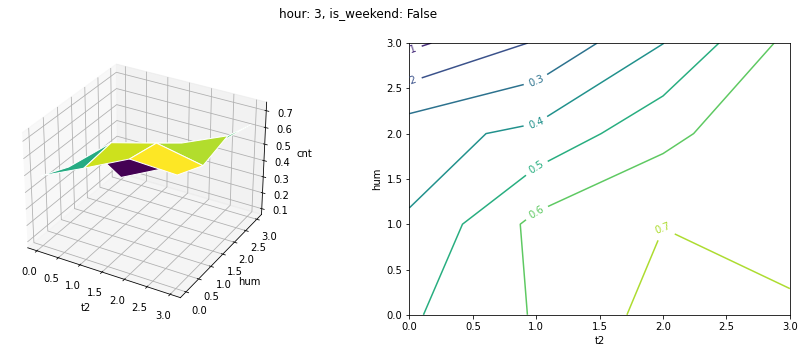

In [88]:
for i in range(4):
  plot3d(range(4), range(4), np.array(answers[i]),
         't2', 'hum', 'cnt', f'hour: {i}, is_weekend: False')

### Custom model

In the base model the features that directly influence cnt are:
hum, wind_speed, t1, season, is_weekend, hour, is_holiday, weather_code, t2
 - wind_speed, range {0,...,3},
 - is_weekend, range {True, False},
 - hour, range {0,...,3},
 - is_holiday, range {True, False},
 - weather_code, range {0,...,6},
 - t2, range {0,...,3},

Let's see how they influence it.

In [89]:
inference = VariableElimination(custom_model)

In [102]:
answers_t1 = []
answers_t2 = []
answers_hum = []
answers_wind_speed = []
answers_weather_code = []
answers_is_holiday = []
answers_is_weekend = []
answers_season = []
answers_hour = []

for score in range(4):
    for feature, answers in [('hour', answers_hour),
                            ('t2', answers_t2),
                            ('wind_speed', answers_wind_speed),]:
        evidence = {feature : score}
        answers.append(inference.query(["cnt"], evidence, show_progress=False).values[1])
        
for score in range(7):
    for feature, answers in [('weather_code', answers_weather_code),]:
        evidence = {feature : score}
        answers.append(inference.query(["cnt"], evidence, show_progress=False).values[1])

for score in (True, False):
    for feature, answers in [('is_weekend', answers_is_weekend)]:
        evidence = {feature : score}
        answers.append(inference.query(["cnt"], evidence, show_progress=False).values[1])


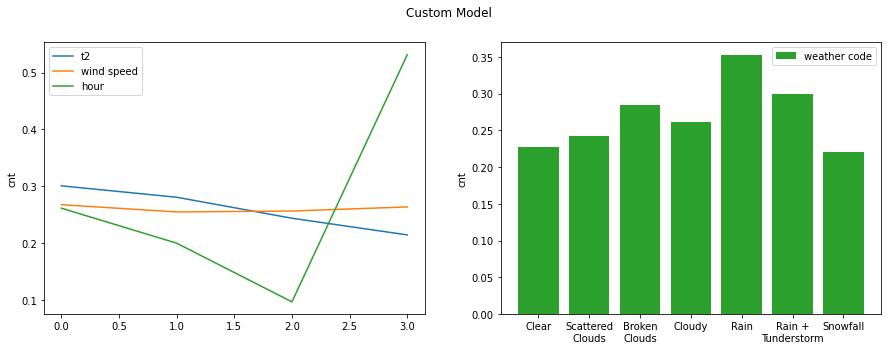

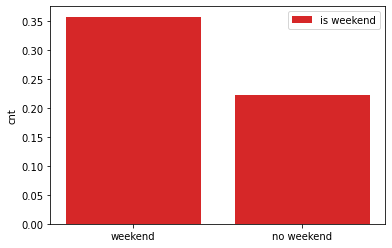

In [106]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
ax = axes[0]
fig.suptitle(f"Custom Model")
ax.set_ylabel('cnt')
ax.plot(answers_t2, label='t2')
ax.plot(answers_wind_speed, label='wind speed')
ax.plot(answers_hour, label='hour')
ax.legend()
ax2 = axes[1]
ax2.set_ylabel('cnt')
ax2.bar(range(7), answers_weather_code, label='weather code', color='C2')
ax2.set_xticks(range(7))
ax2.set_xticklabels(['Clear', 'Scattered\nClouds', 'Broken\nClouds', 'Cloudy', 'Rain', 'Rain +\nTunderstorm', 'Snowfall'])
ax2.legend()
plt.show()

plt.bar(range(2), answers_is_weekend, label='is weekend', color='C3')
plt.legend()
plt.ylabel('cnt')
plt.xticks(range(2), labels=['weekend', 'no weekend'])
plt.show()

In [113]:
def weather_name(code):
    name = None
    if code == 0:
        name = 'Clear'
    elif code == 1:
        name = 'Scattered Clouds'
    elif code == 2:
        name = 'Broken Clouds'
    elif code == 3:
        name = 'Cloudy'
    elif code == 4:
        name = 'Rain'
    elif code == 5:
        name = 'Rain with Thunderstorm'
    elif code == 6:
        name = 'Snowfall'
    return name

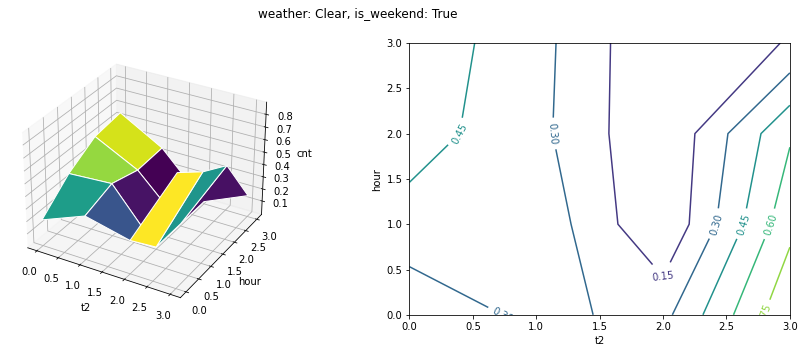

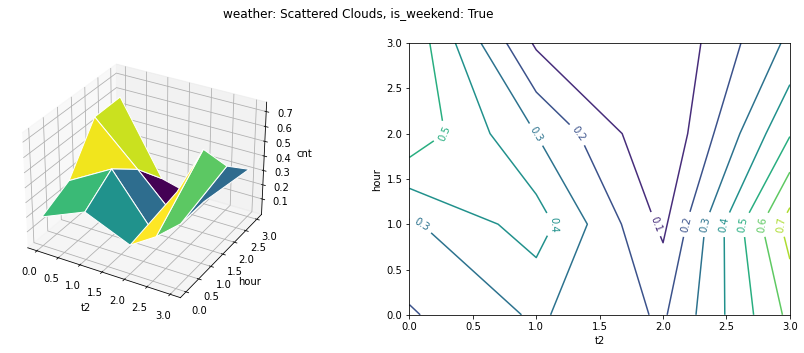

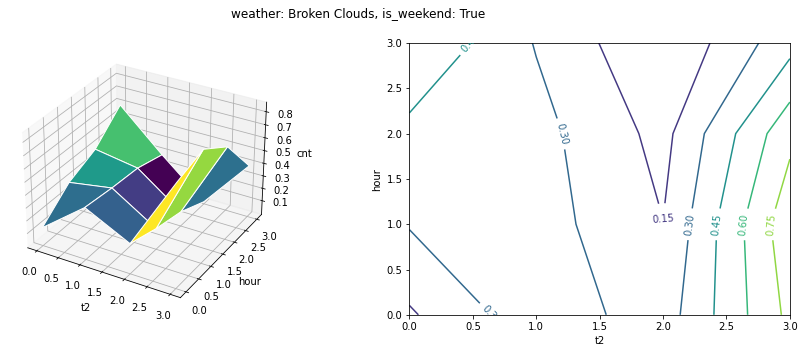

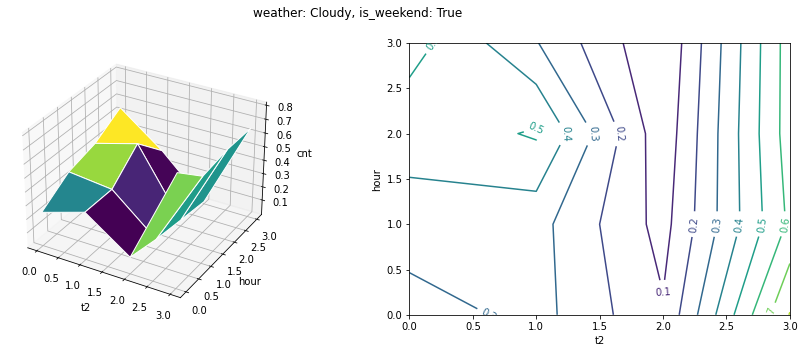

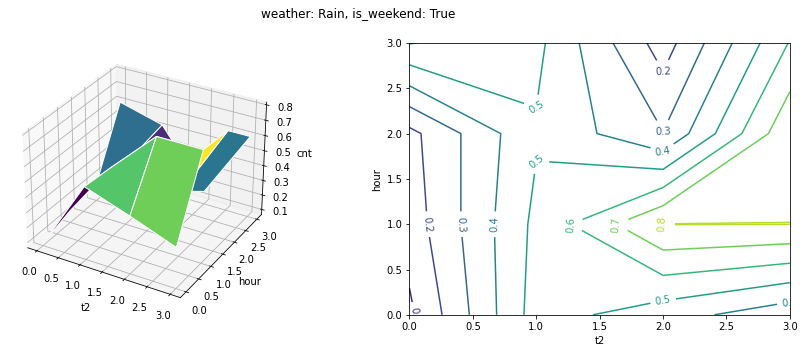

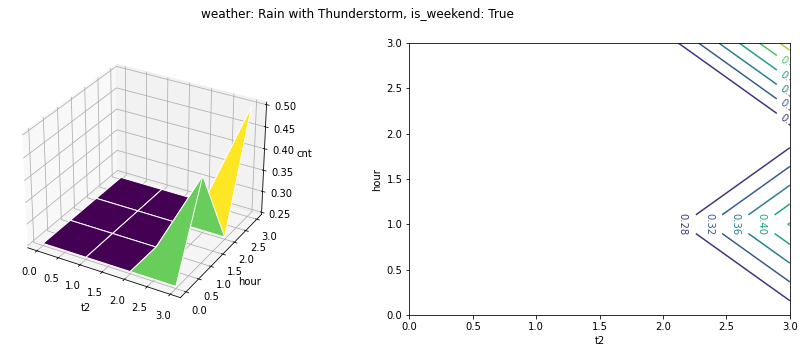

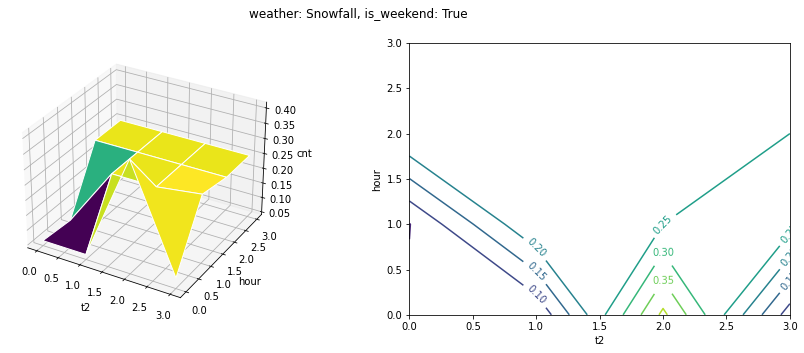

In [114]:
answers = [[[] for _ in range(4)] for _ in range(7)]
for weather_code in range(7):
    for t2 in range(4):
        for hour in range(4):
            evidence = {"t2": t2, "hour": hour, 'weather_code': weather_code, 'is_weekend': True}
            answers[weather_code][t2].append(inference.query(["cnt"], evidence, show_progress=False).values[1])

for i in range(7):
    plot3d(range(4), range(4), np.array(answers[i]),
         't2', 'hour', 'cnt', f'weather: {weather_name(i)}, is_weekend: True')

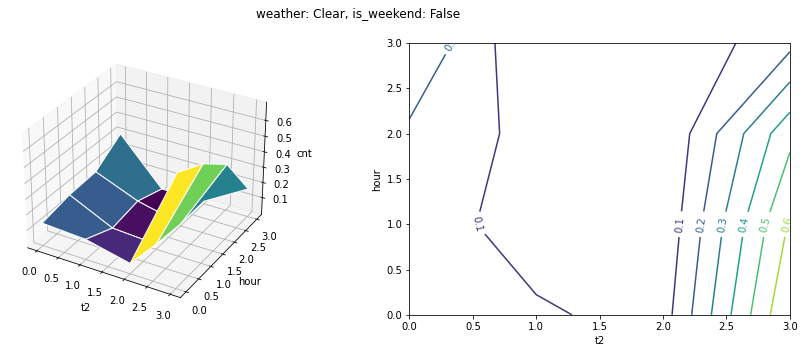

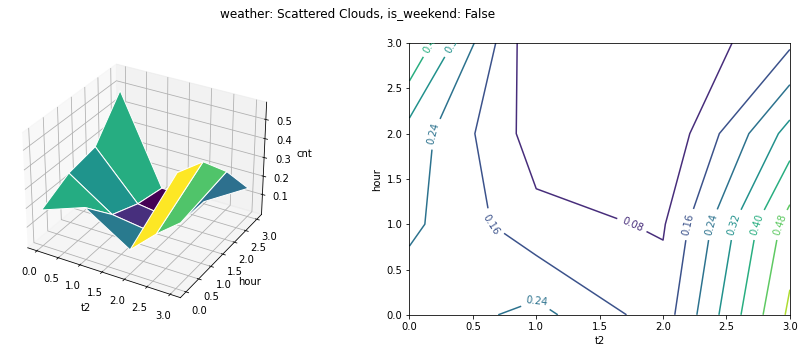

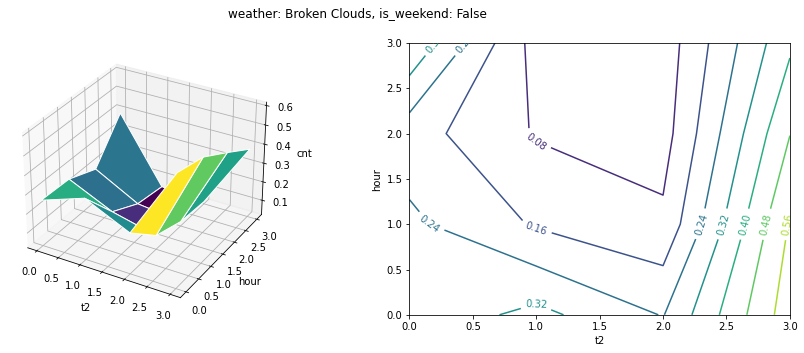

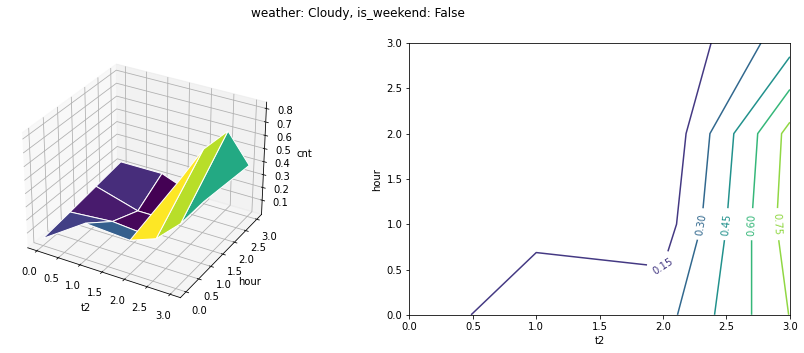

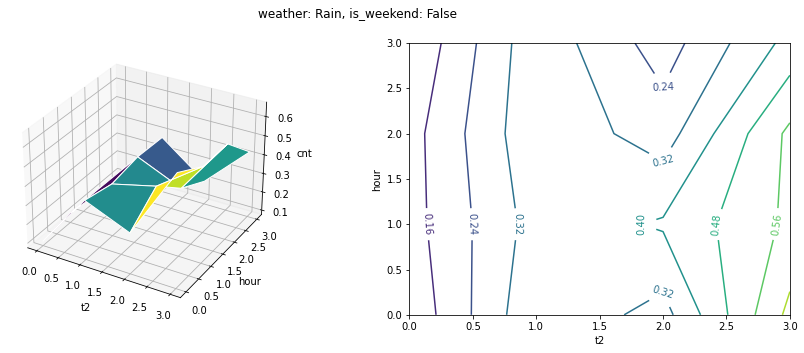

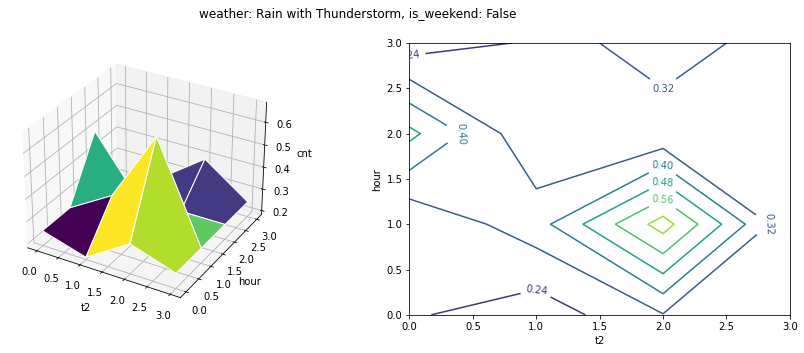

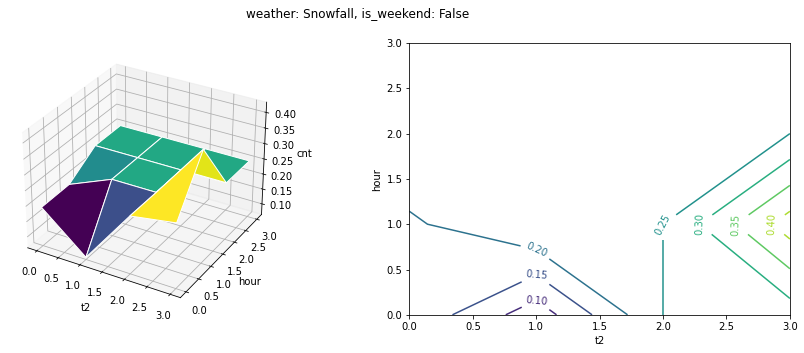

In [115]:
answers = [[[] for _ in range(4)] for _ in range(7)]
for weather_code in range(7):
    for t2 in range(4):
        for hour in range(4):
            evidence = {"t2": t2, "hour": hour, 'weather_code': weather_code, 'is_weekend': False}
            answers[weather_code][t2].append(inference.query(["cnt"], evidence, show_progress=False).values[1])

for i in range(7):
    plot3d(range(4), range(4), np.array(answers[i]),
         't2', 'hour', 'cnt', f'weather: {weather_name(i)}, is_weekend: False')

What said for the previous model still holds, but now we can see that long tracks (last cinquile) have the highest probability.